# Training Notebook
This notebook loads data, trains a neural network model, and saves it for later evaluation.

In [1]:
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tempfile import TemporaryDirectory


In [ ]:
# Class for our dataset model
class GreekLettersDataset(Dataset):
    def __init__(self, x, t, transform=None):
        self.x = x
        self.t = t
        self.transform = transform

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        # Ensure the data is reshaped correctly
        img = self.x[idx].reshape(100, 100).astype(np.float32)
        img = np.stack([img] * 3, axis=0)  # Convert to 3 channels
        if self.transform:
            img = self.transform(torch.tensor(img))
        else:
            img = torch.tensor(img, dtype=torch.float32) / 255.0 
        label = self.t[idx]
        return img, label
    
# Label mapping for Greek letters    
label_map = { 
    0: 'alpha', 1: 'beta', 2: 'gamma', 3: 'delta', 4: 'epsilon', 5: 'eta', 6: 'theta', 7: 'lambda', 8: 'mu', 9: 'pi' 
}

# Function to split the dataset into training and testing sets (80% train, 20% test)
def load_and_split_data(x_path, t_path, test_size=0.2, random_state=42, save_dir='../data/generated/'):
    """
    Load the dataset, split it into training and testing sets, and save the splits to CSV files.

    Args:
        x_path   : Path to the features CSV file.
        t_path   : Path to the labels CSV file.
        save_dir : Directory to save the split CSV files.

    """
    # Load the data
    x = pd.read_csv(x_path, header=None).values.astype(np.float32)
    t = pd.read_csv(t_path, header=None).values.flatten().astype(np.int64)
    
    # Split into training and testing sets
    x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=test_size, random_state=random_state)
    
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save the splits to CSV files
    pd.DataFrame(x_train).to_csv(f'{save_dir}x_train_split.csv', header=False, index=False)
    pd.DataFrame(x_test).to_csv(f'{save_dir}x_test_split.csv', header=False, index=False)
    pd.DataFrame(t_train).to_csv(f'{save_dir}t_train_split.csv', header=False, index=False)
    pd.DataFrame(t_test).to_csv(f'{save_dir}t_test_split.csv', header=False, index=False)
    
    print(f"Data splits saved to {save_dir}")
    return x_train, x_test, t_train, t_test

In [3]:
# Function to visualize a subset of the dataset (verify dataset is loaded correctly) Rewrite...
def visualize_dataset(x_path, t_path, num_images=5):
    x = pd.read_csv(x_path, header=None).values.astype(np.float32)
    t = pd.read_csv(t_path, header=None).values.flatten().astype(np.int64)

    dataset = GreekLettersDataset(x, t)
    total_samples = len(dataset)

    step = max(1, total_samples // num_images) 
    selected_indices = list(range(0, total_samples, step))[:num_images]

    cols = 5
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() 

    for i, idx in enumerate(selected_indices):
        img, label = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)  
        letter = label_map[label]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {letter}")
        axes[i].axis('off')

    for i in range(len(selected_indices), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Training Function

In [43]:
def train(x_train, x_test, t_train, t_test, device, num_epochs=10, save_path='../model/best_model.pt'):
    """
    Train a ResNet18 model on the provided dataset and save the best model. 
    Note: This heavily follows the PyTorch tutorial for training a model using Transfer Learning.

    Args:
        x_train    : Training features.
        x_test     : Testing features.
        t_train    : Training labels.
        t_test     : Testing labels.
        device     : Device to train the model on (CPU or GPU).
        num_epochs : Number of epochs to train the model.
        save_path  : Path to save the best model permanently.

    """
    # Transformations for the dataset to comply with ResNet18 input requirements
    # Augmentation is applied to the training set to see if it can improve performance
    train_transform = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(15),
        transforms.Resize((224, 224)),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])
    
    # Create datasets and dataloaders
    train_dataset = GreekLettersDataset(x_train, t_train, transform=train_transform)
    test_dataset = GreekLettersDataset(x_test, t_test, transform=test_transform)

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
        'val': DataLoader(test_dataset, batch_size=32, shuffle=False)
    }
    dataset_sizes = {
        'train': len(train_dataset),
        'val': len(test_dataset)
    }

    # Load the ResNet18 model
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # Update the final layer for 10 classes (Greek letters)
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Scheduler for learning rate adjustment
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)

    # Track the best model
    best_acc = 0.0

    print("Starting Training...\n")
    since = time.time()

    # Create a temporary directory to save the best model
    with TemporaryDirectory() as tempdir:
        temp_best_model_path = os.path.join(tempdir, 'best_model.pt')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimization only in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if validation accuracy improves
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), temp_best_model_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_acc:.4f}')
        
        # Save the best model permanently to the specified path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(torch.load(temp_best_model_path), save_path)
        print(f'Best model saved permanently to {save_path}')
        
        # Load the best model weights
        model.load_state_dict(torch.load(save_path))

    return model

# Execution

In [18]:
# Input path declarations
x_data_path = '../data/x_train_project.csv'
t_data_path = '../data/t_train_project.csv'

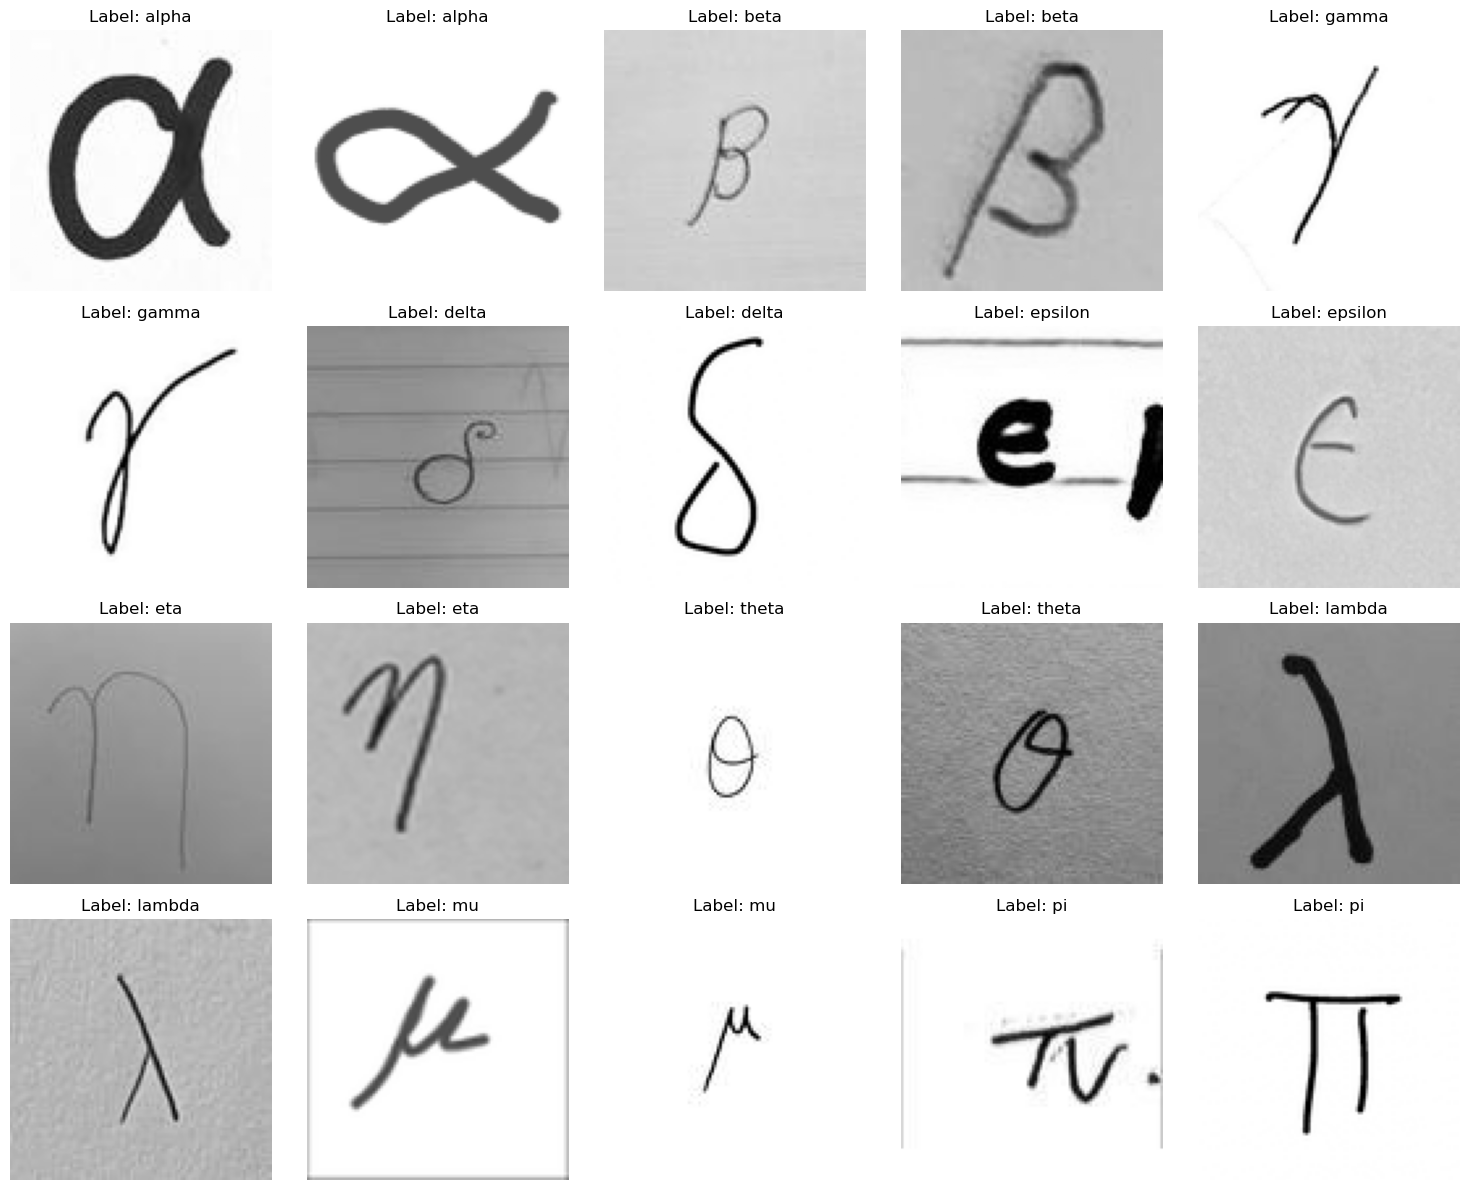

In [19]:
# Visualize the dataset to ensure it is loaded correctly
visualize_dataset(x_data_path, t_data_path, num_images=20)

In [34]:
# Load and split the data
x_train, x_test, t_train, t_test = load_and_split_data(x_data_path, t_data_path, random_state=42)

Data splits saved to ../data/generated/


In [21]:
# Define the device for training (GPU in personal environment/CPU in Test environment)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Device Name: NVIDIA GeForce RTX 3080


In [44]:
# Train the model
model = train(x_train, x_test, t_train, t_test, device, num_epochs=10)

Starting Training...

Epoch 1/10
----------
train Loss: 1.1926 Acc: 0.6119
val Loss: 0.7041 Acc: 0.7742

Epoch 2/10
----------
train Loss: 0.3050 Acc: 0.9033
val Loss: 0.9242 Acc: 0.7092

Epoch 3/10
----------
train Loss: 0.1645 Acc: 0.9463
val Loss: 0.3060 Acc: 0.9017

Epoch 4/10
----------
train Loss: 0.0518 Acc: 0.9858
val Loss: 0.0495 Acc: 0.9867

Epoch 5/10
----------
train Loss: 0.0219 Acc: 0.9956
val Loss: 0.0527 Acc: 0.9858

Epoch 6/10
----------
train Loss: 0.0156 Acc: 0.9973
val Loss: 0.0434 Acc: 0.9867

Epoch 7/10
----------
train Loss: 0.0093 Acc: 1.0000
val Loss: 0.0390 Acc: 0.9908

Epoch 8/10
----------
train Loss: 0.0089 Acc: 0.9996
val Loss: 0.0368 Acc: 0.9917

Epoch 9/10
----------
train Loss: 0.0078 Acc: 1.0000
val Loss: 0.0358 Acc: 0.9908

Epoch 10/10
----------
train Loss: 0.0073 Acc: 0.9996
val Loss: 0.0361 Acc: 0.9925

Training complete in 1m 21s
Best validation accuracy: 0.9925
Best model saved permanently to ../model/best_model.pt
